<a href="https://colab.research.google.com/github/luksz/BalancingPole/blob/main/FinalGroup5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**SC3000 Lab Assignment 1 Group 5**
## Group Members and Contributions:


Kuan Hong Hui Joy U2221261D
- Building DQN Agent
- Analysis of DQN Agent


Tan Pin Yee U2221027H
- Builidng Q Learning Agent
- Analysis of Q Learning Agent


Celyna Teo U2221037F
- Running of cells
- Formatting of notebook
- Technical Analysis




#**Setting up the enviroment**
1. Installing Neccessary Library
2. Importing Neccessary Library
3. Set up a virtual enviroment


With reference to the Colab Jupyter notebook provided, we start off with installing and importing neccessary library and set up two virtual enviroment for Q-Learning and DQN. In this project, we will be comparing the two agent to see how they perform in the cartpole enviroment. This Jupyter notebook can be ran using colab.



In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
!pip3 install gymnasium[classic_control]

  Using cached pygame-2.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0


In [ ]:
# For q learning
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# For Dqn
import gymnasium
import math
import matplotlib
from collections import namedtuple, deque # Python build-in data structure
from itertools import count

# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cpu")

#For Task 3
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

The function below is used to **display the video file** in the Jupyter notebook. It checks for the presence of an .mp4 file in the 'video' directory, and if found, it embeds the video into an HTML element and displays it in the notebook. If no .mp4 file is found, it prints a message indicating that no video was found

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Task 1: Development of an RL agent**

Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.
*   Test out 2 different RL technique
*   Training the agent



For this cartpole experiment, we have chosen to develop 2 different reinforcement learning model : **Q-Learning and DQN**.

Our goal is to observe and compare their learning processes. By implementing both QLearning and DQN, we aim to assess their performance (i.e. how fast they learn, how steady they are) and determine which method is more effective for training the CartPole agent. This comparative analysis will provide insights to help us pick the best method for teaching the CartPole what to do.

## **Method 1 : Q-Learning**

Q-Learning is known to be a more basic reinforcement learning algorithm due to its 'model-free' nature where the agent directly learn policies without needing a pre-defined model of the environment. It uses previously learned “states” which have been explored to consider future moves and stores this information inside a Q-Table.




In [ ]:
# Creating the CartPole environment
env = gym.make("CartPole-v1")

After  iterating through multiple training sessions and adjusting various parameters, we found this set of hyperparameters that consistently yield the best outcomes:


1.   **LEARNING_RATE** = 0.1: This rate moderates the update of Q-value estimates, allowing a balance between rapid learning and convergence stability.

2. **DISCOUNT** = 0.95: With a strong preference for future rewards, this factor helps the agent to consider long-term outcomes while still prioritizing immediate gains.

3. **EPISODES** = 6000: A large number of training episodes gives the agent enough experience to explore the environment thoroughly.

4. **EPS** = 1: The starting epsilon value. Starting with pure exploration, the agent initially makes decisions randomly, which prevents early bias in strategy development.

5. **EPS_DEC** = 0.99995: This slow decay rate for epsilon ensures extensive exploration before the agent begins exploiting learned behaviors.


In [ ]:
#Define parameters
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 10000 #
EPS = 1 # Epsilon
EPS_DEC = 0.99995 #Epsilon decay value


#define observation space discretization
#Observation:the num of bins for each dim
Observation = [30, 30, 50, 50]
#np_array_win_size: size of each bin
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

In [ ]:
#initialize Q-table with random values
q_table = np.random.uniform(low=0, high=1, size=(Observation + [env.action_space.n]))

#Function to get the discrete state from the continuous state
def get_discrete_state(state):
    discrete_state = state / np_array_win_size + np.array([15, 10, 1, 10])
    return tuple(discrete_state.astype(int))


*   The code below will initiate the training loop for the reinforcement learning agent. Within each episode/loop, it will return the initial continuous observation/state of the environment, which is then converted into a discrete state. Discrete states are required as Q-Learning relies on a Q-Table where state-action pairs are mapped to their corresponding Q values. For Q-learning to update and reference this table effectively, it must have a finite number of states and actions to enumerate and store these values explicitly.

*   **Epsilon-greedy policy** is used to balance exploration and exploitation by choosing between these two randomly. The variable, **Epsilon**, refers to the probability of choosing to  explore, allowing the agent to mostly exploit with a small chance of exploring.

*   During each step of an episode, the agent will choose to either exploit the **best current action**, P(1-`EPS`), **or explore a random action**, P(`EPS`). This decision is made by comparing a randomly generated number to the value of epsilon (`EPS`).

*   After each episode, epsilon (`EPS`) is decayed to gradually shift the agent's priority from exploration to exploitation. To achieve this, we multiplied epsilon(`EPS`) by the **epsilon decay rate(`EPS_DEC`)** and set a minimum threshold of 0.05 to ensure it doesnt fall below this value.

*   The total reward of each episode is stored in `train_rewards`. Once the training is completed, Matplotlib will generate a graph, plotting the stored training rewards. This visualization helps us to understand the agent's learning progress over the episodes.






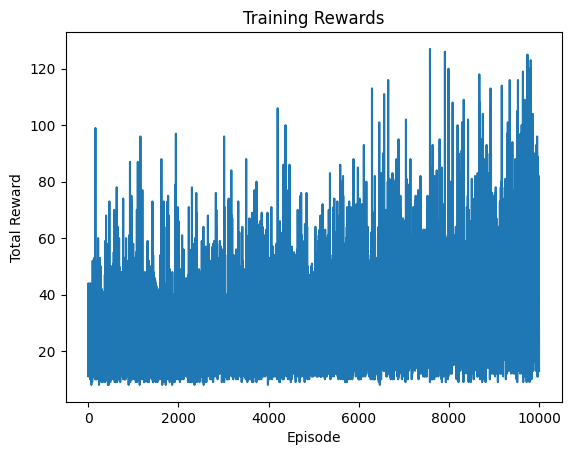

In [ ]:
# Training the RL Agent
train_rewards = []

for episode in range(EPISODES + 1):

    currentState = env.reset()

    discrete_state = get_discrete_state(currentState)
    done = False
    ep_reward = 0


    #Epsilon-greedy policy
    while not done:
        if np.random.random() > EPS:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)

        # Step action
        new_state, reward, done, _ = env.step(action)
        ep_reward += reward
        new_discrete_state = get_discrete_state(new_state)

        #Updating the Q-table
        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_discrete_state

    #Decay epsilon
    if EPS > 0.05:
        EPS = max(EPS * EPS_DEC, 0.05)
        # Store the total reward for this episode
    train_rewards.append(ep_reward)

# Plotting the training rewards
plt.plot(train_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.show()

env.close()

There is an overall upward trend, where there are initial low rewards that increase over time, signaling learning progress.

A random state (in an ndarray with shape (4,)) is generated using `env.reset()` where each value in the array represents a position or a velocity of the randomly generated observation.

The improved RL agent (after training) then chooses an action (an ndarray of (0,1) where 0 represents tilting left and 1 represents tilting right) to maximise the rewards.

In [ ]:
#sampling a random state from the cart pole env
currentState = env.reset()
if np.random.random() > EPS:
    action = np.argmax(q_table[discrete_state])
else:
    action = np.random.randint(0, env.action_space.n)

print("Observation: ", currentState)
print("Action: ", action)

env.close()

Observation:  [-0.02307498  0.04336707  0.03142758 -0.00265772]
Action:  1


## **Method 2 : DQN**

DQN (Deep Q-Networks) is a reinforcement learning algorithm that combines the usage of both Q-Learning and neural networks, and is mainly used for high-dimensional observation spaces (CartPole is considered a simple low-dimensional environment) where Q-Learning may not be as efficient.

In [ ]:
envd = gymnasium.make("CartPole-v1", render_mode="rgb_array")

- `Transition` namedtuple: Bundles `state`, `action`, `next_state`, and `reward` representing a timestep in an environment.
- `ReplayMemory` class: Implements a fixed-capacity replay buffer for storing transitions.
- Initialization: Uses a `deque` with maximum length equal to the specified capacity, ensuring old experiences are discarded when full.
- `push` method: Adds a new transition to the replay memory.
- `sample` method: Randomly selects a batch of transitions for training, aiding in experience replay and training stability.
- `__len__` method: Returns the current number of stored transitions, allowing for easy size checks with Python's built-in `len()` function.

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""

        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

* `DQN class`: Inherits nn.Module, forming a neural network for Q-learning.

* `init` method: Initializes network layers, mapping observations to actions.

* `super()` invocation: Integrates parent nn.Module properties.

* Layers setup: `layer1` (observations to 128 nodes), `layer2` (128 to 128 nodes), `layer3` (128 nodes to actions).

* `forward` method: Processes inputs through the network, employing ReLU activations between layers, to output action values.

In [ ]:
class DQN(nn.Module): #parent child OOP

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__() # super , init following the parent
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

After iterating through multiple training sessions and adjusting various parameters, we found this set of hyperparameters that consistently yield the best outcomes:

1. **BATCH_SIZE** = 128: In DQN learning, a smaller batch size is often preferred as it helps in reducing the correlation between samples and stabilizes training.

2. **GAMMA** = 0.99: Discount factor for future rewards, emphasizing the importance of long-term gains slightly more than immediate rewards.

3. **EPS_START** = 0.9: Initial value of epsilon for the epsilon-greedy policy, favoring exploration at the beginning of training.

4. **EPS_END** = 0.05: Final value of epsilon, ensuring that the policy retains a minimum level of exploration even after extensive training.

5. **EPS_DECAY** = 1000: The rate at which epsilon is decayed, controlling the transition from exploration to exploitation over training episodes.

6. **TAU** = 0.005: A smaller value of TAU can facilitate more frequent updates to the target network, enhancing the stability and speed of convergence in DQN learning.

7. **LR** = 1e-4 (0.0001): A slightly higher Learning Rate may be beneficial in DQN learning, as it helps in faster convergence while still maintaining stability. However, careful monitoring of learning dynamics is crucial to prevent overshooting or instability which can be caused by overly high learning rates.

* `n_actions = envd.action_space.n`: Retrieves the number of possible actions in the environment `envd`. This is used to define the output size of the DQN model.

* `state, info = envd.reset()`: Resets the environment to its initial state and returns the initial observation (continuous state) and additional info if any.

* `n_observations = len(state)`: Determines the size of the observation space by the length of the state vector, which is used as the input size for the DQN model.

Two DQN models are instantiated: policy_net and target_net.

* `policy_net`: Selects actions during training.

* `target_net`: Generates the target Q-values for updates.

* The models are defined with `n_observations` as input size and `n_actions` (obtained above) as output size as `n_observations` is fed to the neural network to generate `n_actions` as possible actions that can be taken. However only one optimal action will be selected based on the q values returned for each possible action.

* `target_net.load_state_dict(policy_net.state_dict())`: Initializes the target network with the same weights as the policy network to start training in sync.

* `optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)`: An AdamW optimizer is initialized for the policy_net with a learning rate LR. The `amsgrad=True` parameter is a variant of the Adam optimization algorithm that can provide better convergence in some cases.

* `memory = ReplayMemory(10000):` Initializes a replay memory of a specified size (10,000 in this case) to store transitions `(state, action, reward, next state)`. This is used for experience replay, a crucial technique to stabilize and improve DQN training.

* `select_action(state):` A function that takes the current state as input and decides whether to exploit the best-known action (using the policy network) or explore a random action, based on the epsilon-greedy strategy. The `EPS_START`, `EPS_END`, and `EPS_DECAY` parameters (defined and justified above) control how the value of epsilon decreases over time, balancing exploration and exploitation.

* `plot_steps()`: A function to plot the rewards obtained per episode during training. It uses Matplotlib to create a dynamic plot that updates after each episode.

* `steps_done`: A counter for the total number of steps (actions taken) across all episodes, used in the epsilon-greedy strategy to decrease epsilon over time.

* `episode_steps`: A list to track the number of steps per episode, used for plotting the training progress.

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = envd.action_space.n
state, info = envd.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[envd.action_space.sample()]], device=device, dtype=torch.long)

episode_steps = []

def plot_steps(show_result=False):
    plt.figure(1)
    steps_t = torch.tensor(episode_steps, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(steps_t.numpy())
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

`optimize_model()` is required to train the DQN agent. It is the optimization step where the neural network (the policy network) is updated based on a batch of experiences.

* It starts by checking if the replay memory (`memory`) has enough samples (`BATCH_SIZE`) to form a batch. If not, the function returns immediately without performing an update on the DQN agent. This ensures that there's a sufficient diversity of experiences to learn from.

* It then samples a batch of experiences (`transitions`) from the replay memory. Each experience typically consists of a tuple `(state, action, reward, next_state)`. The batch is then organized by the Transition namedtuple (see above) for easier access to the components.

* To prepare the batch for training, it creates masks for filtering out experiences where the next state is `None` (indicating the end of an episode).
It concatenates all non-final next states, current states, actions taken, and rewards received from the batch for efficient batch processing.

* It then calculates the Q-values for the actions taken in each state of the batch (`state_action_values`) using the policy network. This is achieved by passing the state batch through the policy network and then using the `gather` method (from PyTorch library) to select the Q-values for the actions that were actually taken.

* For all non-final next states, it calculates the maximum Q-value for the next state using the target network (to ensure stability) and stores them in the `next_state_values` tensor. This operation is performed without gradient tracking (`torch.no_grad()`) as we're using these values for updates, not for training the target network directly.

* It calculates the expected Q-values (`expected_state_action_values`) as the sum of the rewards received for the current actions and the discounted maximum future rewards, indicated by the term (`next_state_values` * `GAMMA`). This represents the target Q-values we want our policy network to predict.

* It calculates the loss using the `SmoothL1Loss` (neural networks) function between the predicted Q-values (`state_action_values`) and the target Q-values (`expected_state_action_values`). This loss measures how well the policy network predicts the expected future rewards.
The optimizer's gradients are reset (`optimizer.zero_grad()`), the loss is backpropagated (`loss.backward()`), and the gradients are clipped to prevent exploding gradients.
Finally, the optimizer performs a parameter update step (`optimizer.step()`).

This function is called iteratively during the training process, allowing the DQN agent to learn from the experiences by adjusting the weights of the policy network to minimize the difference between the predicted Q-values and the expected Q-values. The use of a separate target network for estimating future rewards and the replay memory for sampling experiences are key strategies to stabilize training and improve learning efficiency.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


* `num_episodes:` the number of episodes for which the agent will be trained

* `train_reward:` a list used to track the rewards obtained in each episode

* `episode_steps:` a list used to track the number of steps in each episode



Each episode begins by resetting the environment `(envd.reset())` and initializing the state tensor.

* `episode_steps.append(0)` initializes the step count for the current episode.

* `action = select_action(state)` determines the action to take based on the current state using the select_action function using the epilson-greedy policy.

* `envd.step(action.item())` returns the new observation, reward, termination status (terminated), truncation status (truncated), and additional info.



The reward is wrapped in a tensor, and the next_state is prepared or set to `None` if the episode has terminated, indicating the end of the episode.

The transition `(state, action, next_state, reward)` is stored in the replay memory `memory.push(state, action, next_state, reward)`.

`optimize.model()` is called to train the DQN agent (explained above).

Rewards are accumulated in `train_reward` for analysis.

The code updates the target network's parameters by blending them with the policy network's parameters. The factor `TAU` is used to control the mixing (soft updating). This helps to stabilize training by keeping the target network's parameters slowly tracking the policy network's parameters.

The loop keeps repeating until the episode is `terminated` or `truncated`, of which it will then exit the step loop to go into a new episode. After all episodes are completed, the average reward per episode is calculated and printed. The results are plotted to show the training outcome.

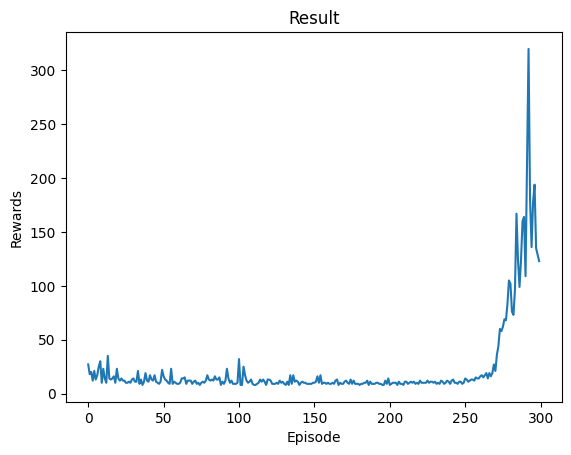

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
#testing old working code
num_episodes = 300 #Number of episodes to run during training phase
train_reward = []

for i_episode in range(num_episodes):
    state, info = envd.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_steps.append(0)

    for step in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = envd.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        train_reward.append(reward)
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        episode_steps[-1] += 1

        if done:
            plot_steps()
            break

mean_reward = sum(train_reward) / num_episodes



plot_steps(show_result=True)
plt.ioff()
plt.show()


The graph shows the rewards starting low and fluctuating slightly, with a rapid increase after episode 250, suggesting a significant improvement in its learning performance.

#**Task 2: Demonstrate the effectiveness of the RL Agent**
*   Test the trained models against 100 episodes
*   Plot the graph for each method
*   Make comparision between the 2 methods

## **Method 1 : Q-learning**
Running the trained Q-learning agent against 100 episodes and plotting its cumulative rewards onto a graph to see the effectiveness of the training.
The average cumulative reward should be above 195.

Average cumulative reward: 292.93
Is my agent good enough? True


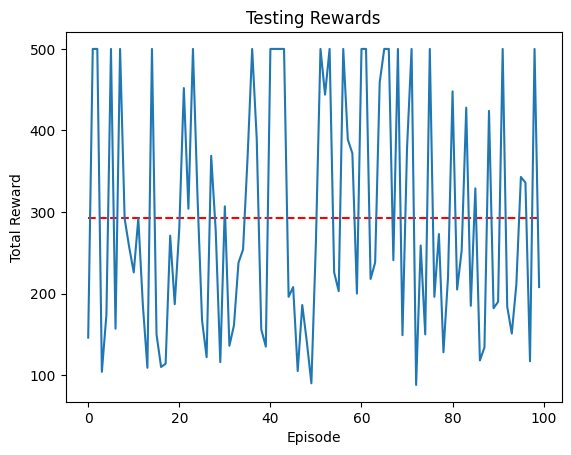

In [ ]:
# Testing the agent
num_episodes = 100
max_reward = 500
test_rewards = []

for i in range(num_episodes):
    state = env.reset()
    discrete_state = get_discrete_state(state)
    total_reward = 0

    for t in range(max_reward):
      #select an action based on the highest Q-value for its current state
        action = np.argmax(q_table[discrete_state])
        next_state, test_reward, done, _ = env.step(action)
        total_reward += test_reward
        state = next_state
        discrete_state = get_discrete_state(state)

        if done:
            break

    #Printing results of each episode
    test_rewards.append(total_reward)

# Calculate the avg cumulative reward and  accessing its performance
avg_reward = sum(test_rewards) / num_episodes
print("Average cumulative reward:", avg_reward)
print("Is my agent good enough?", avg_reward > 195)

#Plot the test result for visualisation
plt.plot([avg_reward] * num_episodes, linestyle='--', color='r', label='Average Reward')
plt.plot(test_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Testing Rewards')
plt.show()

#close env
env.close()

## **Method 2 : DQN**

Average cumulative reward over 100 episodes: 144.44


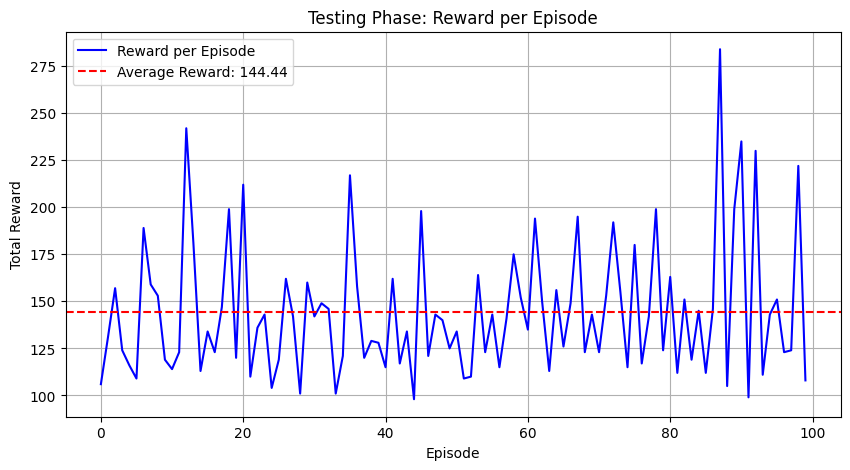

In [ ]:
# Testing  the effectiveness of the RL agent
def select_best_action(state):
    with torch.no_grad():
        return policy_net(state).max(1).indices.view(1, 1)

test_episodes = 100
test_rewards = []

for i_episode in range(test_episodes):
    state, info = envd.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    while True:
        action = select_best_action(state)
        observation, reward, terminated, truncated, _ = envd.step(action.item())
         # Accumulate reward
        total_reward += reward

        if terminated or truncated:
            break

        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the total reward for this episode
    test_rewards.append(total_reward)

# Calculate average reward across all test episodes
average_reward = sum(test_rewards) / len(test_rewards)
print(f"Average cumulative reward over {test_episodes} episodes: {average_reward}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(test_rewards, label='Reward per Episode', color='blue')  # Plot total reward per episode
plt.axhline(y=average_reward, color='red', linestyle='--', label=f'Average Reward: {average_reward:.2f}')  # Plot average reward
plt.title('Testing Phase: Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


## **Comparision Between Q-Learning and DQN**

We will now compare the results between Deep Q-Network and Q Learning in the CartPole environment.

- Q-Learning have achieved an average cumulative reward of 292.93 > 195.
- Deep Q-Network have achieved an average cumulative reward of 144.44 < 195.





###**Analysis of results:**

#### **State Space and Discretization**

- Q-learning operates effectively in discrete state and action spaces. The CartPole environment, though continuous, has a *relatively low-dimensional state space* that includes the cart's position and velocity, and the pole's angle and rotation rate. These can be discretized with reasonable resolution, allowing Q-learning to map states to actions via a Q-table.
- DQN utilizes neural networks to approximate the Q-function, which allows it to handle continuous state spaces directly. While this is advantageous for complex environments, the *simplicity* of CartPole means the benefit of this function approximation *might not outweigh the added complexity and computational demand.*

#### **Learning Stability and Convergence**

- Q-learning can achieve stable learning and convergence to an optimal policy in CartPole by adequately discretizing the state space and properly tuning the learning rate and discount factor. Its tabular approach is straightforward and *less prone to the instability issues* that can arise from function approximation methods.
- DQN introduces concepts like experience replay and target networks to mitigate the instability and divergence issues inherent in using function approximators for Q-learning. While these techniques enable DQN to learn effectively in more complex environments, they also *introduce additional hyperparameters and complexities*, which might *not be necessary* for an environment as straightforward as CartPole.

#### **Sample Efficiency and Computational Complexity**

- Q-learning, with a properly discretized state space, can be quite *sample efficient* in environments like CartPole, where the agent can quickly experience a wide variety of states and learn effective policies.
- DQN, while powerful, often *requires a significant number of samples* to train due to the indirect nature of function approximation. The use of a replay buffer helps by recycling past experiences, but the need to train a deep neural network inherently involves *more computational resources and time*, especially when considering the iterative nature of updating the target network.

#### **Exploration Strategies**

- Both Q-learning and DQN commonly employ epsilon-greedy strategies for exploration. However, the effectiveness of such strategies can differ based on the learning mechanism. In the *relatively simple* CartPole environment, the straightforward exploration of Q-learning can quickly lead to an effective policy *without the need for the more nuanced exploration* that might be beneficial in environments with more complex or deceptive reward structures where DQN's capacity to generalize from high-dimensional inputs could be advantageous.

#### **Theoretical Considerations**

- Q-learning is *guaranteed to converge* to the optimal policy in *finite MDPs* (Markov Decision Processes) given infinite exploration and a proper learning rate schedule. Given that CartPole *can be modeled as a finite MDP* (with discretized states), Q-learning holds a theoretical convergence guarantee under these conditions.
- DQN, due to its reliance on function approximation, *does not hold the same convergence guarantees*. Approximation errors, especially in simpler environments, can lead to *suboptimal policies* or *prolonged training times* to achieve comparable performance to Q-learning.

#### **Practical Implications**

- In practice, the choice between Q-learning and DQN for CartPole would also consider factors such as implementation complexity, computational resources, and the scalability of the chosen approach to more complex scenarios. Q-learning is more straightforward and efficient for CartPole.


In summary, while DQN offers powerful tools for dealing with high-dimensional or continuous state spaces, its advantages might not translate into significant performance benefits for a relatively simple and well-understood environment like CartPole, where the simplicity, stability, and efficiency of Q-learning could make it more suitable.

# Task 3: Render one episode

In [ ]:
#Rendering an episode from Qlearning
env = RecordVideo(gym.make("CartPole-v1"), "./video")

print("Observation Space: ", env.observation_space)
print("Action Space       ", env.action_space)

obs = env.reset()
max_reward = 500
total_reward = 0

for t in range(max_reward):
      #select an action based on the highest Q-value for its current state
        action = np.argmax(q_table[discrete_state])
        next_state, test_reward, done, _ = env.step(action)
        total_reward += test_reward
        state = next_state
        discrete_state = get_discrete_state(state)

        env.render(mode = "rgb_array")
        time.sleep(0.01)
        if done:
            break

# Print the cumulative reward for this episode and display the video
print("Total reward:", total_reward)
env.close()
show_video()

Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space        Discrete(2)


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: http

Total reward: 398.0
